In [1]:
import os
import glob
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import time
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from scipy.ndimage.measurements import label
%matplotlib inline

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)
#     heatmap = np.zeros_like(img[:, :, 0])

#     print('Min, Max pixels:', img[:,:,0].min(), img[:,:,0].max())
#     print('Data Type:', img.dtype)   
    
    windows = []
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2YCrCb)
    for s in scales:
        if s != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/s), np.int(imshape[0]/s)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell)-1
        nyblocks = (ch1.shape[0] // pix_per_cell)-1 
        nfeat_per_block = orient*cell_per_block**2
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell)-1 
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*s)
                    ytop_draw = np.int(ytop*s)
                    win_draw = np.int(window*s)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
#                     heatmap[ytop + ystart:ytop_draw + win_draw + ystart, xbox_left:xbox_left + win_draw] += 1
                    windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

#     return draw_img, heatmap
    return draw_img, windows


def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


def visualize(fig, rows, columns, imgs, titles):
    for index, img in enumerate(imgs):
        plt.subplot(rows, columns, index+1)
        plt.title(index+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[index])
        else:
            plt.imshow(img)
            plt.title(titles[index])
            
def extract_features(imgs, color_space='BGR', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        image = image.astype(np.float32)
        # apply color conversion if other than 'RGB'
        if color_space != 'BGR':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat is True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat is True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat is True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(
                        feature_image[:, :, channel],
                        orient, pix_per_cell, cell_per_block, vis=False,
                        feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(
                    feature_image[:, :, hog_channel], orient,
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    global previous
    global current
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [3]:
# car_dir = 'vehicles/'
# non_car_dir = 'non-vehicles/'

# car_files = os.listdir(car_dir)
# non_car_files = os.listdir(non_car_dir)

# for folder in car_files:
#     for img_name in glob.glob(car_dir + folder + '/*'):
#         img = cv2.imread(img_name)
#         flipped = cv2.flip(img, 1)
#         change_pct = random.uniform(0.4, 1.2)
#         hsv = cv2.cvtColor(flipped, cv2.COLOR_BGR2HSV)
#         hsv[:,:,2] = hsv[:,:,2] * change_pct
#         image_brightness = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
#         cv2.imwrite(img_name[:-4] + '_flipped.png', flipped)
# print('cars done')
        
# for folder in non_car_files:
#     for img_name in glob.glob(non_car_dir + folder + '/*'):
#         img = cv2.imread(img_name)
#         flipped = cv2.flip(img, 1)
# #         change_pct = random.uniform(0.4, 1.2)
# #         hsv = cv2.cvtColor(flipped, cv2.COLOR_BGR2HSV)
# #         hsv[:,:,2] = hsv[:,:,2] * change_pct
# #         image_brightness = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
#         cv2.imwrite(img_name[:-4] + '_flipped.png', flipped)
        
# print('non cars done')

In [4]:
cars = []
non_cars = []

car_dir = 'vehicles/'
non_car_dir = 'non-vehicles/'

car_files = os.listdir(car_dir)
non_car_files = os.listdir(non_car_dir)

for imgtype in car_files:
    cars.extend(glob.glob(car_dir + imgtype + '/*'))

for imgtype in non_car_files:
    non_cars.extend(glob.glob(non_car_dir + imgtype + '/*'))

print('Length of cars: ', len(cars))
print('Length of non-cars: ', len(non_cars))

Length of cars:  8792
Length of non-cars:  9353


Min, Max pixels: 6 205
Data Type: uint8


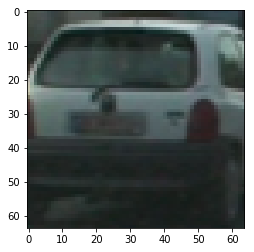

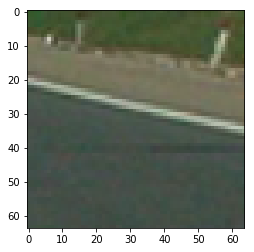

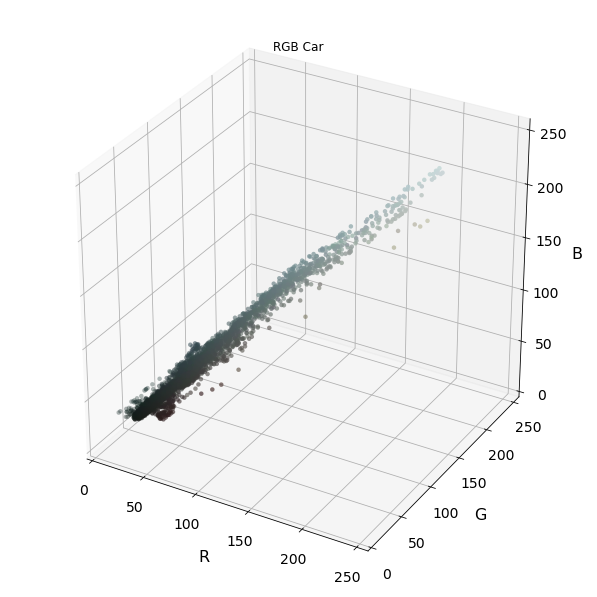

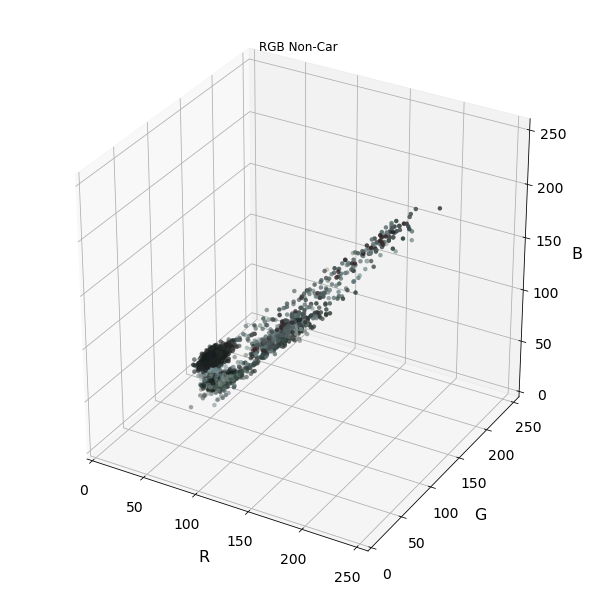

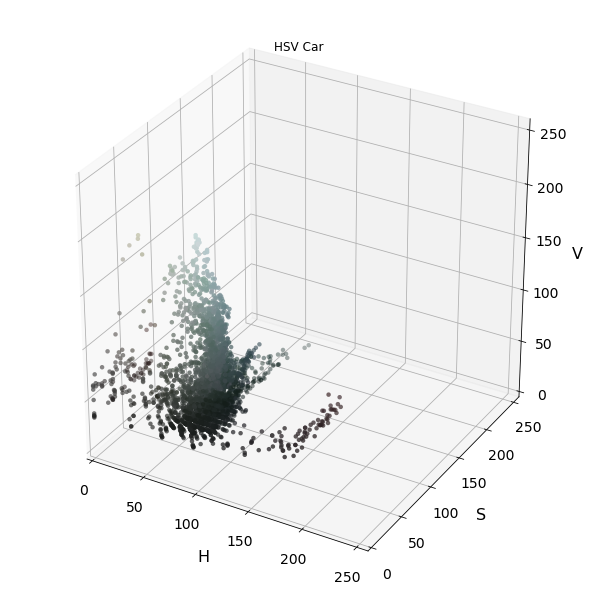

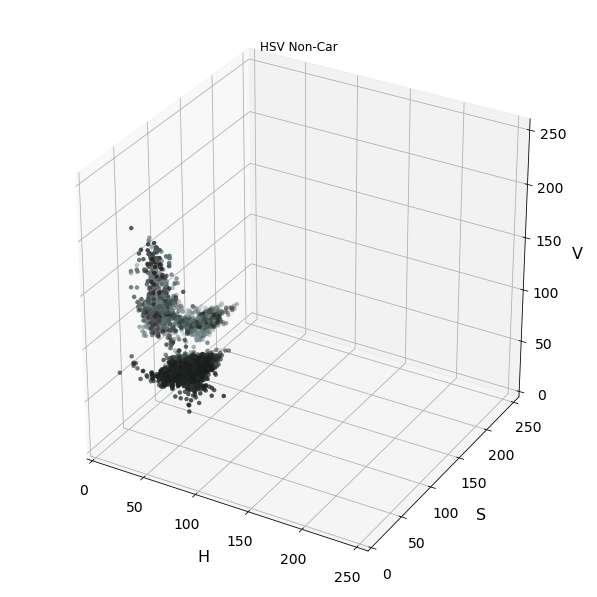

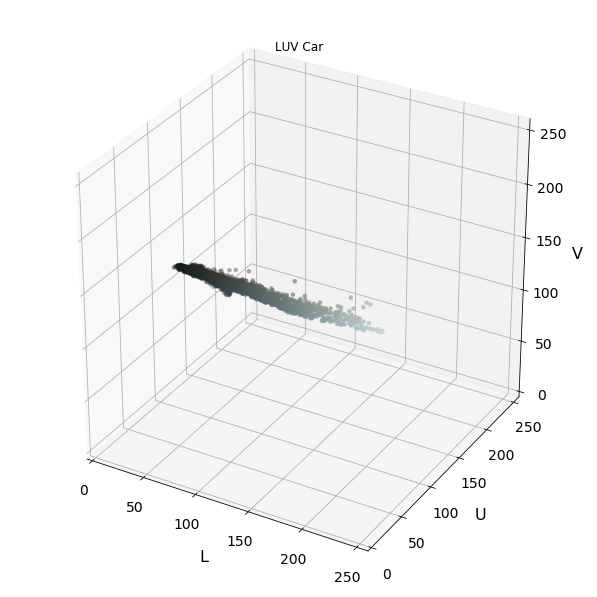

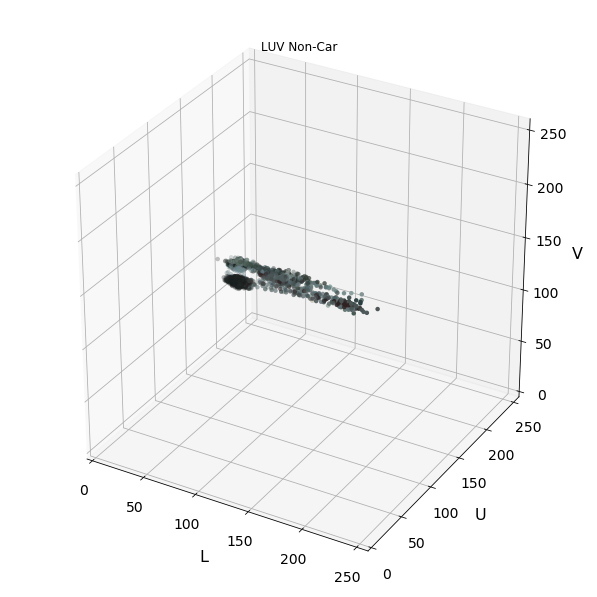

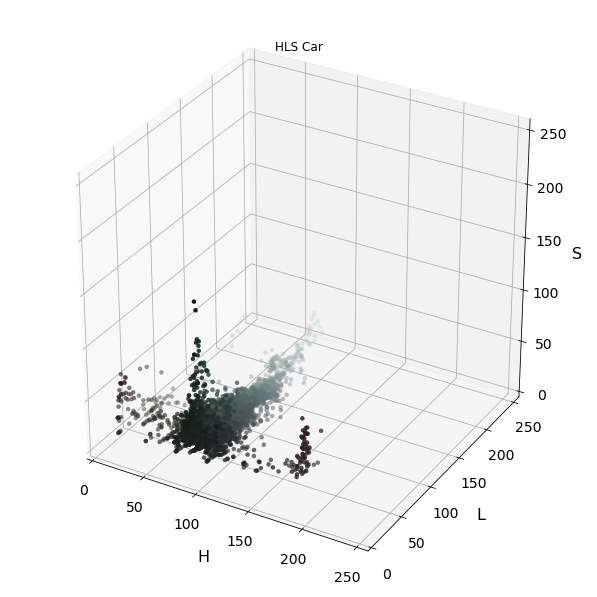

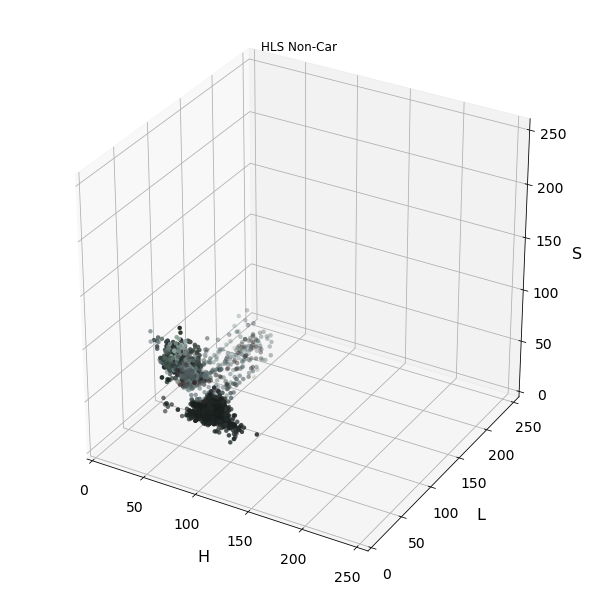

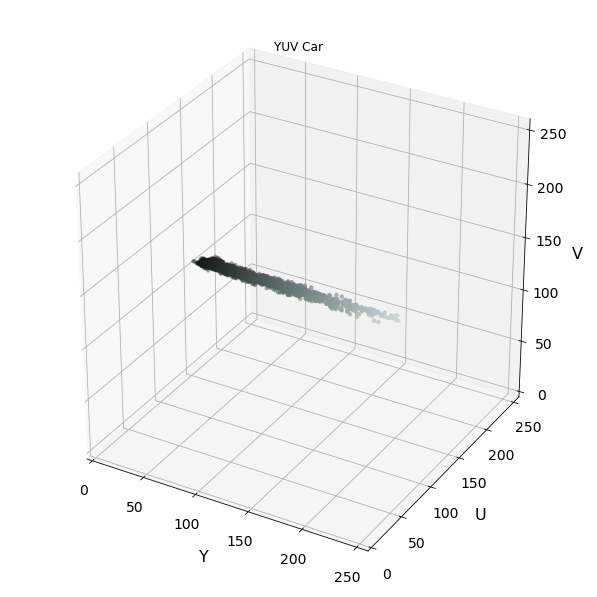

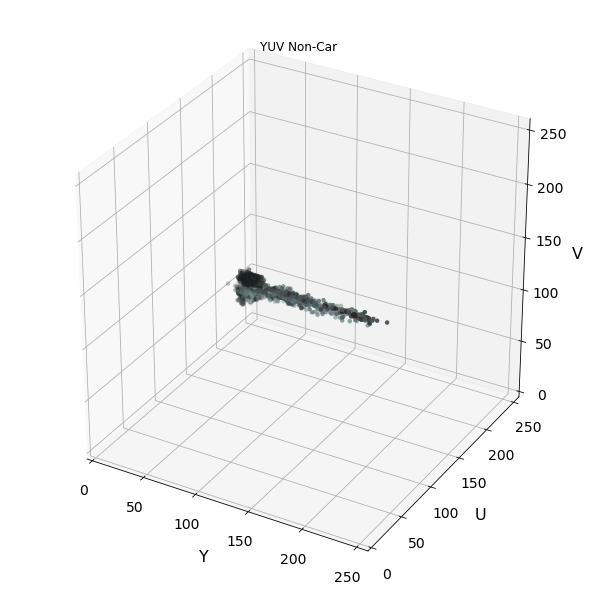

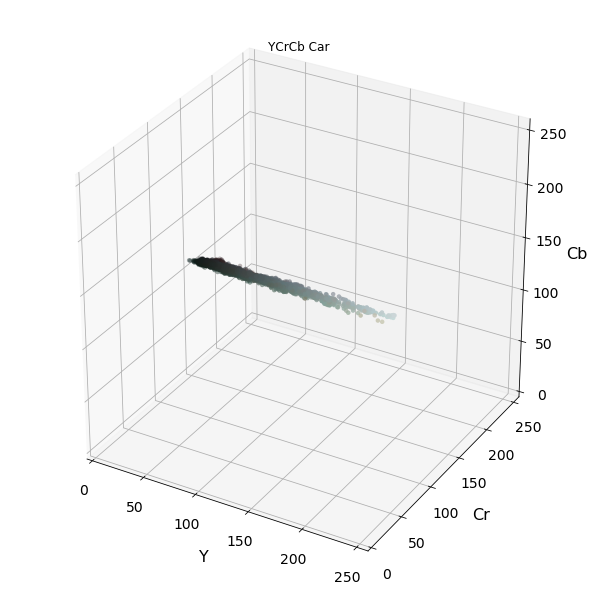

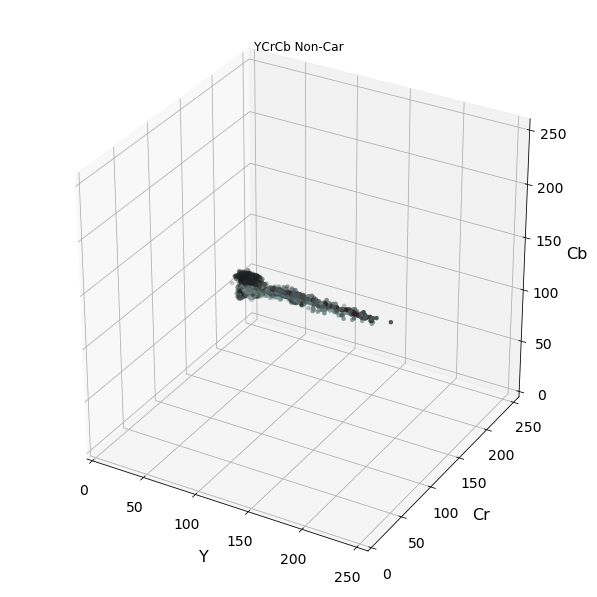

In [5]:
# Get random indices
car_indices = np.random.randint(0, len(cars))
non_car_indices = np.random.randint(0, len(non_cars))

car_image = cv2.imread(cars[car_indices])
RGB_car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(RGB_car_image)
print('Min, Max pixels:', RGB_car_image[:,:,0].min(), RGB_car_image[:,:,0].max())
print('Data Type:', RGB_car_image.dtype)

non_car_image = cv2.imread(non_cars[non_car_indices])
RGB_non_car_image = cv2.cvtColor(non_car_image, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(RGB_non_car_image)

# Convert subsampled image to desired color space(s)
rgb_car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB)
rgb_non_car_image = cv2.cvtColor(non_car_image, cv2.COLOR_BGR2RGB)
hsv_car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2HSV)
hsv_non_car_image = cv2.cvtColor(non_car_image, cv2.COLOR_BGR2HSV)
luv_car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2LUV)
luv_non_car_image = cv2.cvtColor(non_car_image, cv2.COLOR_BGR2LUV)
hls_car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2HLS)
hls_non_car_image = cv2.cvtColor(non_car_image, cv2.COLOR_BGR2HLS)
yuv_car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2YUV)
yuv_non_car_image = cv2.cvtColor(non_car_image, cv2.COLOR_BGR2YUV)
ycrcb_car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2YCrCb)
ycrcb_non_car_image = cv2.cvtColor(non_car_image, cv2.COLOR_BGR2YCrCb)
rgb_image2 = cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB)/255.

# Plot and show
plot3d(rgb_car_image, rgb_image2)
plt.title('RGB Car')
plt.show()

plot3d(rgb_non_car_image, rgb_image2)
plt.title('RGB Non-Car')
plt.show()

plot3d(hsv_car_image, rgb_image2, axis_labels=list("HSV"), axis_limits=[(0, 255), (0, 255), (0, 255)])
plt.title('HSV Car')
plt.show()

plot3d(hsv_non_car_image, rgb_image2, axis_labels=list("HSV"), axis_limits=[(0, 255), (0, 255), (0, 255)])
plt.title('HSV Non-Car')
plt.show()

plot3d(luv_car_image, rgb_image2, axis_labels=list("LUV"), axis_limits=[(0, 255), (0, 255), (0, 255)])
plt.title('LUV Car')
plt.show()

plot3d(luv_non_car_image, rgb_image2, axis_labels=list("LUV"), axis_limits=[(0, 255), (0, 255), (0, 255)])
plt.title('LUV Non-Car')
plt.show()

plot3d(hls_car_image, rgb_image2, axis_labels=list("HLS"), axis_limits=[(0, 255), (0, 255), (0, 255)])
plt.title('HLS Car')
plt.show()

plot3d(hls_non_car_image, rgb_image2, axis_labels=list("HLS"), axis_limits=[(0, 255), (0, 255), (0, 255)])
plt.title('HLS Non-Car')
plt.show()

plot3d(yuv_car_image, rgb_image2, axis_labels=list("YUV"), axis_limits=[(0, 255), (0, 255), (0, 255)])
plt.title('YUV Car')
plt.show()

plot3d(yuv_non_car_image, rgb_image2, axis_labels=list("YUV"), axis_limits=[(0, 255), (0, 255), (0, 255)])
plt.title('YUV Non-Car')
plt.show()

plot3d(ycrcb_car_image, rgb_image2, axis_labels=['Y', 'Cr', 'Cb'], axis_limits=[(0, 255), (0, 255), (0, 255)])
plt.title('YCrCb Car')
plt.show()

plot3d(ycrcb_non_car_image, rgb_image2, axis_labels=['Y', 'Cr', 'Cb'], axis_limits=[(0, 255), (0, 255), (0, 255)])
plt.title('YCrCb Non-Car')
plt.show()

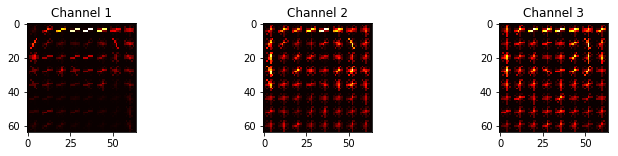

In [7]:
example_images = []

for i in range(0, 3): 
    hog_features, car_hog_image = get_hog_features(ycrcb_car_image[:,:,i], 9, 8, 2, vis=True, feature_vec=True)
    example_images.append(car_hog_image)


titles = ['Channel 1', 'Channel 2', 'Channel 3']
fig = plt.figure(figsize=(12, 2))
visualize(fig, 1, 3, example_images, titles)

## Train Classifier

In [8]:
# Define feature parameters
color_space = 'YCrCb'  # RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'  # 0, 1, 2, "ALL"
spatial_size = (32, 32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

t = time.time()

car_features = extract_features(
            cars, color_space=color_space, spatial_size=spatial_size,
            hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
            cell_per_block=cell_per_block, hog_channel=hog_channel,
            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

non_car_features = extract_features(
            non_cars, color_space=color_space, spatial_size=spatial_size,
            hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
            cell_per_block=cell_per_block, hog_channel=hog_channel,
            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

print(round(time.time()-t, 2), 'Seconds to extract features...')

X = np.vstack((car_features, non_car_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.10, random_state=rand_state)

print('Using: ', orient, 'orientations, ', pix_per_cell,
      'pixels per cell, ', cell_per_block, 'cells per block, ',
      hist_bins, 'histogram bins, and ', spatial_size, 'spatial sampling')
print('Feature vector length: ', len(X_train[0]))

# Linear SVC
# svc = SVC(kernel='rbf')
svc= LinearSVC(C=0.0001)
# from sklearn.ensemble import RandomForestClassifier
# svc = RandomForestClassifier(n_estimators=5, min_samples_leaf=2)
t = time.time()
svc.fit(X_train, y_train)

print(round(time.time()-t, 2), 'Seconds to train SVC...)')
# Check accuracy
print('Test Accuracy: ', round(svc.score(X_test, y_test), 4))

109.78 Seconds to extract features...
Using:  9 orientations,  8 pixels per cell,  2 cells per block,  32 histogram bins, and  (32, 32) spatial sampling
Feature vector length:  8460
29.94 Seconds to train SVC...)
Test Accuracy:  0.9934


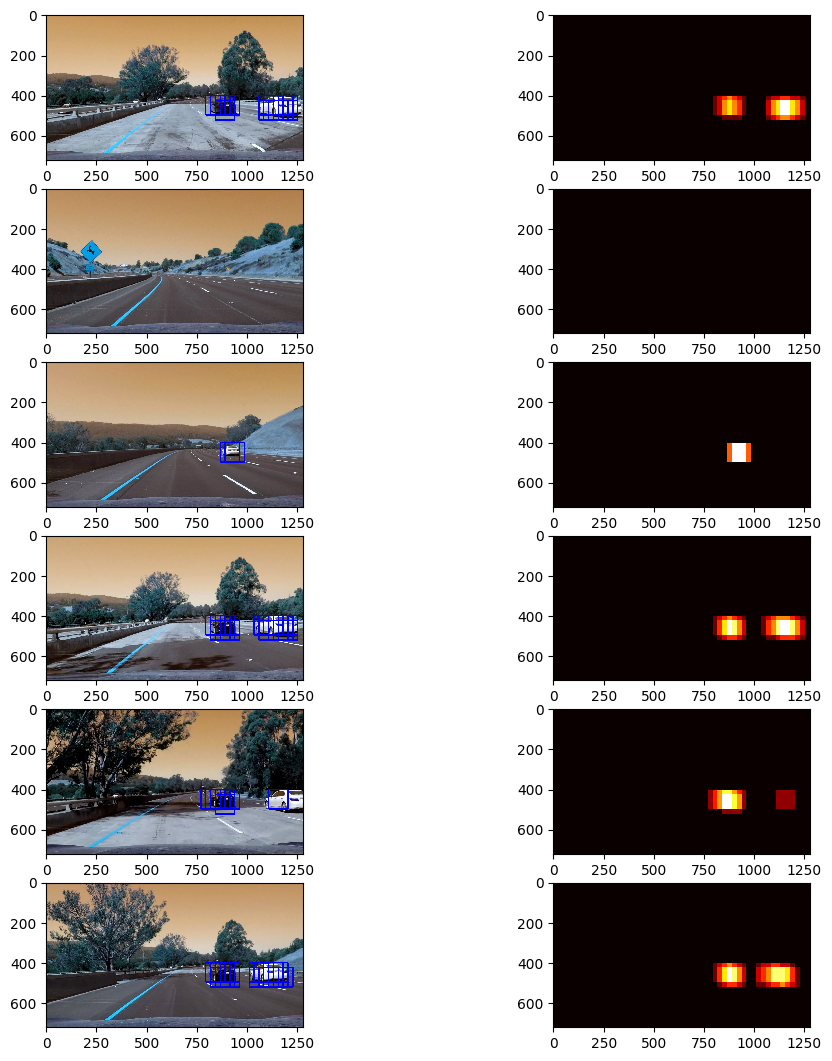

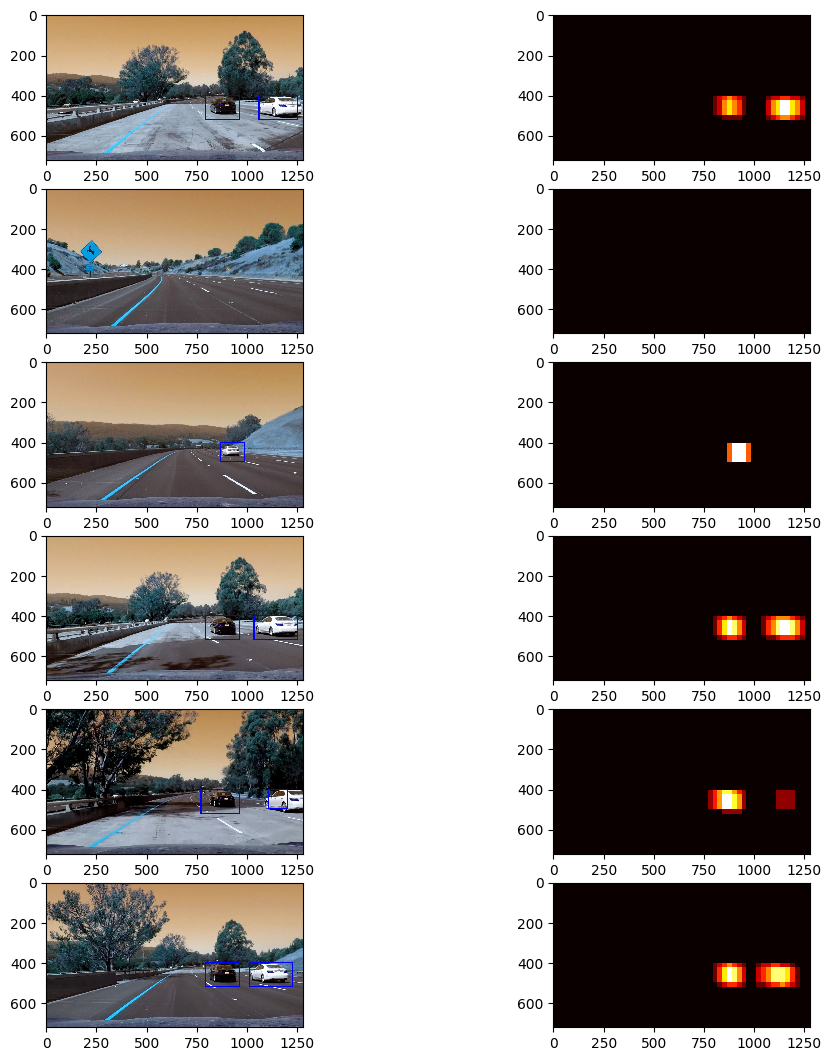

In [9]:
searchpath = 'test_images/*'
test_images = glob.glob(searchpath)
heat = []
heat_titles = []
final = []
y_start_stop = (400, 650)
scales = [1.5]

for img in test_images:
    img = cv2.imread(img)
    output_img, windows = find_cars(img, y_start_stop[0], y_start_stop[1], scales, svc, X_scaler, orient,
                                    pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    heat_map = np.zeros_like(img[:, :, 0])
    heat_map = add_heat(heat_map, windows)
    heat_map = apply_threshold(heat_map, 0)
    heat_map = np.clip(heat_map, 0, 255)
    
    heat.append(output_img)
    heat.append(heat_map)
    heat_titles.append(' ')
    heat_titles.append(' ')
        
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    final.append(draw_img)
    final.append(heat_map)
    
fig = plt.figure(figsize=(12, 18), dpi=100)
visualize(fig, 8, 2, heat, heat_titles)

fig = plt.figure(figsize=(12, 18), dpi=100)
visualize(fig, 8, 2, final, heat_titles)

## Average Heatmaps

In [10]:
previous_frames = []


def process_image(img):
    global previous_frames
    
    output_img, windows = find_cars(img, y_start_stop[0], y_start_stop[1], scales, svc, X_scaler, orient,
                                    pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    previous_frames.append(windows)
    previous_frames = previous_frames[-15:]
    
    heat_map = np.zeros_like(img[:, :, 0])
    heat_map = add_heat(heat_map, [window for windows in previous_frames for window in windows])
    heat_map = apply_threshold(heat_map, 5)
    heat_map = np.clip(heat_map, 0, 255)
    if len(previous_frames) > 3:
        labels = label(heat_map)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
        return draw_img
    else:
        return img

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'project_output.mp4'
# clip = VideoFileClip('test_video.mp4', audio=None)
clip = VideoFileClip('project_video.mp4', audio=None)
# clip = clip.subclip(24, 31)
test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


 23%|██▎       | 295/1261 [02:22<08:59,  1.79it/s]